# Practical 2 : Generative and Discriminative Models

## Implementation of Naive Bayes Classifier

In [1]:
%matplotlib notebook
import numpy as np
from math import log # natural log
from math import pi as math_pi
from random import choice
import matplotlib.pyplot as plt

In [2]:
class NBC:
    def __init__(self, feature_types, num_classes, class_labels=[]):
        '''parameters is an array of arrays. Each outer array contains the theta
           values for each class label (the theta_c's)
        '''
        self.feature_types = feature_types
        self.num_classes = num_classes
        self.parameters = np.zeros([num_classes, len(feature_types)], dtype=object)
        if class_labels == []:
            self.class_labels = np.arange(num_classes)
        self.pi_hat = np.empty(num_classes)
        
    def fit(self, Xtrain, ytrain):
        for c in range(self.num_classes):
            indices = np.nonzero(ytrain == self.class_labels[c]) # array of i such that input row X_i has output label c
            self.pi_hat[c] = len(indices) / len(Xtrain)
            for j, feature_type in enumerate(self.feature_types):
                if feature_type == 'r': # guassian model
                    if not indices[0].size == 0:
                        mean = Xtrain[indices][:,j].mean()
                        var = Xtrain[indices][:,j].var()
                    else: # Xtrain so small that no inputs labeled with class c
                        mean = 0 # so set as centered, normalised Gaussian...
                        var = 1
                    if var == 0:
                        var = 1e-6
                    self.parameters[c][j] = (mean, var)
                else: # bernoulli model
                    self.parameters[c][j] = (Xtrain[indices][:,j].sum() + 1)/(Xtrain[indices][:,j].size + 2) # laplace smoothing. Emulates the addition of one extra false input and one extra true input. parameters[c] represents empirical probability of true input
    
    def predict(self, X_new):
        N, D = X_new.shape
        y_hat = np.zeros(N)
        for row in range(N):
            y_hat[row] = self.predict_row(X_new[row])
        return y_hat
    
    def predict_row(self, x_i):
        max_logp = -float('inf')
        for c, class_parameters in enumerate(self.parameters): # loop over classes, C
            logp = self.pi_hat[c] # logp is log p(y=c_current | x_new, theta)
            for j, x_ij in enumerate(x_i): # loop over features, D
                if self.feature_types[j] == 'r': # gaussian model
                    mean, var = class_parameters[j]
                    logp += -log(2*math_pi*var)/2 - (x_ij - mean)**2/(2*var)
                else: # bernoulli model
                    theta = class_parameters[j]
                    logp += log(theta**x_ij * (1-theta)**(1-x_ij))
            if logp > max_logp:
                y_hat_i = self.class_labels[c]
                max_logp = logp
            elif logp == max_logp: # randomise in case of tie
                y_hat_i = choice([y_hat_i, self.class_labels[c]])
                max_logp = logp
        return y_hat_i

## Logistic Regression

In [3]:
from sklearn.linear_model import LogisticRegression

## Handin 1

I would set C=5 such that dividing the entire NLL expression by 5 makes the coefficients of the likelihood term and the regularisation term to be 1 (as in the lecture notes) and 0.1 (as specified), respectively

## Comparing NBC and LR

### Iris Dataset

In [4]:
from sklearn.datasets import load_iris
iris = load_iris()
X_iris, y_iris = iris['data'], iris['target']

### Voting Dataset

In [5]:
import _pickle as cp
X_voting, y_voting = cp.load(open('voting.pickle', 'rb'))

## Function to run a single experiment

In [6]:
def run_experiment(X, y, nbc_params):
    '''Runs a single experiment i.e. fits NBC and LR models using training set
       and computes and returns error on test set for 10 of each classifiers
       with different percentages of training data used
    '''
    N, D = X.shape
    Ntrain = int(0.8 * N)
    shuffler = np.random.permutation(N) 
    Xtrain = X[shuffler[:Ntrain]]
    ytrain = y[shuffler[:Ntrain]]
    Xtest = X[shuffler[Ntrain:]]
    ytest = y[shuffler[Ntrain:]]
    nbc_error = np.zeros(10)
    lr_error = np.zeros(10)
    
    for i in range(10):
        Ntrain, Dtrain = Xtrain.shape
        train_cutoff_index = int((i+1)/10.*Ntrain)
        Xtrain_cut = Xtrain[:train_cutoff_index]
        ytrain_cut = ytrain[:train_cutoff_index]
        # NBC
        nbc = NBC(*nbc_params)
        nbc.fit(Xtrain_cut, ytrain_cut)
        yhat = nbc.predict(Xtest)
        nbc_error[i] = 1 - np.mean(yhat == ytest)
        # LR
        lr = LogisticRegression() # l2-regularisation with C=1
        lr.fit(Xtrain_cut, ytrain_cut)
        yhat = lr.predict(Xtest)
        lr_error[i] = 1 - np.mean(yhat == ytest)
    return nbc_error, lr_error

## Function to run multiple experiments, accumulate results and plot

In [7]:
def run_experiments(num_exprs):
    # Specify the parameters required to intialise NBC classes for the two datasets
    nbc_params_iris = ['r']*4, 3
    nbc_params_voting = ['b']*16, 2
    
    # Create a dictionary in which to accumulate total errors for each dataset,
    # for each classifier type
    total_errors = {('iris','nbc'): np.zeros(10), ('iris','lr'): np.zeros(10),
                    ('voting','nbc'): np.zeros(10), ('voting','lr'): np.zeros(10)}
    
    # Train and test 10 NBC and LR classifiers
    for i in range(num_exprs):
        nbc_error, lr_error = run_experiment(X_iris, y_iris, nbc_params_iris)
        total_errors[('iris','nbc')] += nbc_error
        total_errors[('iris','lr')] += lr_error
        nbc_error, lr_error = run_experiment(X_voting, y_voting, nbc_params_voting)
        total_errors[('voting','nbc')] += nbc_error
        total_errors[('voting','lr')] += lr_error
    
    # Compute mean errors from total errors
    mean_errors = {}
    for data_and_model, errors in total_errors.items():
        mean_errors[data_and_model] = errors / num_exprs
    
    # Plotting
    plt.figure(1)
    plt.plot(np.arange(10,110,10), mean_errors[('iris','nbc')], label='Test error for NBC')
    plt.plot(np.arange(10,110,10), mean_errors[('iris','lr')], label='Test error for LR')
    plt.title('Learning Curves for Iris Dataset')
    plt.ylabel('Error as proportion of misclassifications')
    plt.xlabel('Percentage of training data actually used for training')
    plt.legend(loc='upper right')
    plt.grid()
    
    plt.figure(2)
    plt.plot(np.arange(10,110,10), mean_errors[('voting','nbc')], label='Test error for NBC')
    plt.plot(np.arange(10,110,10), mean_errors[('voting','lr')], label='Test error for LR')
    plt.title('Learning Curves for Voting Dataset')
    plt.ylabel('Error as proportion of misclassifications')
    plt.xlabel('Percentage of training data actually used for training')
    plt.legend(loc='upper right')
    plt.grid()

## Handin 2

<IPython.core.display.Javascript object>


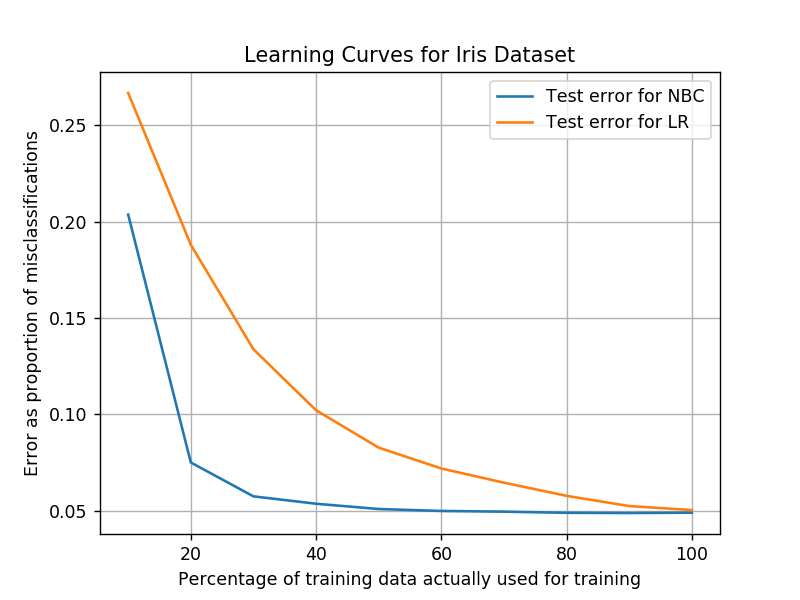

<IPython.core.display.Javascript object>


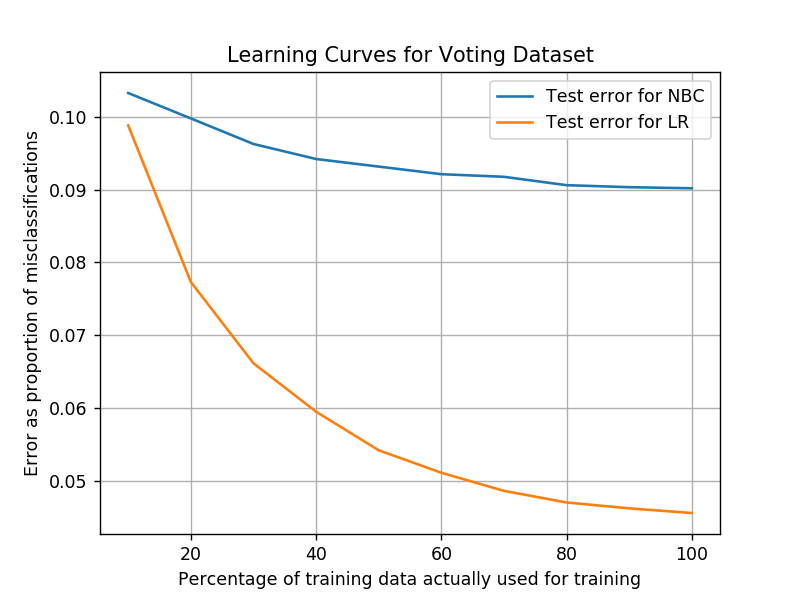

In [8]:
run_experiments(1000)